In [35]:
# import packages
import pandas as pd
import numpy as np

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt

In [129]:
train = pd.read_csv("/Users/abeygailpanganiban/Desktop/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/abeygailpanganiban/Desktop/house-prices-advanced-regression-techniques/test.csv")

In [130]:
train = train[train.GrLivArea < 4000]

In [131]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [132]:
# Log transform the target for better scoring

train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

# #log transform skewed numeric features:

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [133]:
all_data = pd.get_dummies(all_data, dummy_na=False)

In [134]:
# all_data = all_data.fillna(all_data.mean())

In [135]:
X_train_pd = all_data.iloc[:train.shape[0]]
X_test_pd = all_data.iloc[train.shape[0]:]
y_train = train.SalePrice

In [136]:
# X_train = X_train_pd.values

In [137]:
# X_train

In [138]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_train

array([[0.48300349, 0.41326841, 0.36627136, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.49030656, 0.39124518, ..., 0.        , 1.        ,
        0.        ],
       [0.48300349, 0.42998996, 0.42228857, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.55176396, 0.41892525, 0.37952461, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.42998996, 0.39361618, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.46633838, 0.39799815, ..., 0.        , 1.        ,
        0.        ]])

In [139]:
from sklearn.preprocessing import MinMaxScaler

#let's normalzie the data! (rough)

norm = MinMaxScaler().fit(X_train)

X_train = norm.transform(X_train)
# X_test = norm.transform(X_test)

In [140]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.05, 0.001, 0.0005], tol=1e-3, max_iter=2000).fit(X_train, y_train)


In [141]:
y_pred = model_lasso.predict(X_train)

In [142]:
#mean squared error
from sklearn.metrics import mean_squared_error
def rmse_cv(y_true, y_pred):
    rmse= mean_squared_error(y_true, y_pred, squared=False)
    return rmse

In [143]:
rmse_cv(y_train, y_pred)

0.099699077928297

In [144]:
coef = pd.Series(model_lasso.coef_, index = X_train_pd.columns)

In [145]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 104 variables and eliminated the other 183 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

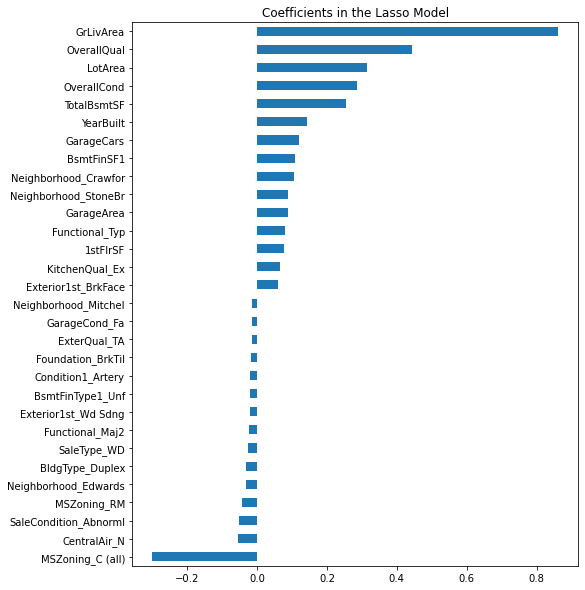

In [146]:
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])




plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

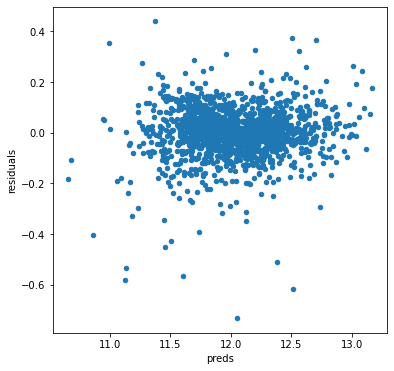

In [88]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")